# PosePipeline : Getting Started

### General Description
The following notebook will help guide and explain PosePipeline which is a pose estimation framework that uses computer vision to detect and track the posture of a person in an image or video. It is assumed that the input for the video was from a single camera (monocular). When working with pose estimation you can approach this with either top-down or bottom-up techniques.
Top-down, first detects and locates all the people in the image (Tracking via bounding box), then extracts the pose (key points) for the person of interest. Bottom-up consists of locating all the key points first then associating them with the person of interest. A downside of top-down approaches is that the pose estimation depends a lot on the performance of the detection model. In a crowded scene, when person detection fails, pose estimation will fail, so perhaps top-down might not be as well suited for crowded multi-person scenes. 

This tutorial notebook will walk through some basic DataJoint operations, video import, and will process videos to obtain 3D keypoints for the person you are analyzing. 


## 0.  Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import io
import os
import sys
import cv2

from IPython.display import Video as JupyterVideo
from IPython.display import HTML
from IPython.display import display
from os import system, name

os.environ["CUDA_VISIBLE_DEVICES"] = '1'        # Set the GPU to use for computation 
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'      # Set the OpenGL platform to use for rendering. omesa is a backend for OpenGL that doesn't require a display. This is useful for running on a server without a display. 

import datajoint as dj
dj.config['display.limit'] = 50                 # Sets the limit for the number of rows to display when running a query, adjust as needed

from pose_pipeline import *
from pose_pipeline.utils.jupyter import play, play_grid


[2025-03-31 18:07:49,876][INFO]: Connecting lwilliamson@jc-compute01.ric.org:3306
[2025-03-31 18:07:50,016][INFO]: Connected lwilliamson@jc-compute01.ric.org:3306


## 1.  Introduction to DataJoint

<details>
<summary>Click to Expand DataJoint Description</summary>
DataJoint is an open-source data mangement framework designed for scientific workflows. It helps researchers organize, process, and query complex data pipelines using Python (or MATLAB) with a clean, relational database backend like MySQL or PostgreSQL.

It is highly reccommneded to look over the DataJoint Documentation: https://datajoint.com/docs/

At its core, DataJoint: Structures your data into tables called schemas (relations) that represent experiments, results, or processing steps. Tracks dependencies between steps in your pipeline. Makes it easy to reproducibly populate, update, and query data — especially when dealing with many subjects, sessions, or models. Instead of manually managing files and folders, DataJoint schemas (a set of linked tables) to ensure data integrity, transparency, and scalability.

DataJoint is a relational database framework and in PosePipe organizes data into three key table (schemas) types. 
(1)	Lookup Tables: Stores predefined, static values used for standardization
(2)	Manual Tables: Contain user-inserted data that links method or experiment details. 
(3)	Computed Tables: ‘Automatically’ generate results by processing upstream data. These tables rely on the populate() command to execute and store results. 
</details> 

### 1.1.  List All Schemas in PosePipe

In [4]:
schemas = dj.list_schemas()
print('The comprehensive list of all the Schemas in the database:')
display(schemas)


schema = dj.schema('pose_pipeline')
print('The tables in the PosePipeline Schema include:')
display(schema.list_tables())

The comprehensive list of all the Schemas in the database:


['mysql',
 'performance_schema',
 'cispd_parkinsons',
 'emgimu_sessions',
 'gait_lab',
 'gait_transformer_training',
 'koa_gait',
 'mocap_sessions',
 'modular_gait',
 'multicamera_tracking',
 'multicamera_tracking_biomechanics',
 'multicamera_tracking_biomechanics_gaitrite',
 'multicamera_tracking_gaitrite',
 'pose_pipeline',
 'pose_pipeline_experimental',
 'prosthetic_gait',
 'prosthetic_gait_sensor_fusion',
 'sys',
 'walking_detection_optimization',
 'sensor_fusion',
 'general_fusion',
 'gait_transformer_annotation',
 'project_fes_augmented',
 'openpbl_session_annotations',
 'project_prosthetic_arm_assessments',
 'project_gait_biomarker_scores',
 'project_biofeedback_games',
 'mocap_sessions_nimblephysics',
 'wustl',
 'project_mmc_splatting',
 'multicamera_tracking_annotation',
 'project_body_models_testing',
 'project_body_models_testing_gaitrite',
 'tutorial',
 'hand_detection',
 'project_clinical_outcomes_measures',
 'test_schema',
 'project_monocular_testing',
 'project_body_mode

The tables in the PosePipeline Schema include:


['#bottom_up_bridging_video_lookup',
 '#bottom_up_method_lookup',
 '#hand_bbox_method_lookup',
 '#hand_pose_estimation_method_lookup',
 '#lifting_method_lookup',
 '#s_m_p_l_method_lookup',
 '#top_down_method_lookup',
 '#tracking_bbox_method_lookup',
 'subject',
 'video',
 'activity',
 'tracking_bbox_method',
 'bottom_up_method',
 'bottom_up_bridging_method',
 '__walking_segments_k_f',
 '__walking_segments_k_f__walking_segment',
 '__open_pose',
 '__center_h_m_r',
 '__bottom_up_bridging',
 '__blurred_video',
 '__tracking_bbox_q_r',
 '__video_info',
 'hand_bbox_method',
 'activity_view',
 '__tracking_bbox',
 '__bottom_up_people',
 '__open_pose_video',
 '__bottom_up_bridging_video',
 '__hand_bbox',
 'person_bbox_valid',
 '__tracking_bbox_video',
 '__tracking_bbox_q_r_by_i_d',
 '__bottom_up_video',
 'hand_pose_estimation_method',
 '__person_bbox',
 '__detected_frames',
 'tracking_bbox_q_r_window_select',
 '__hand_pose_estimation',
 'top_down_method',
 's_m_p_l_method',
 '__open_pose_person'

### 1.2. View the Schemas as Diagram
Diagrams are a great way to visualize the pipeline and understand the flow of data. Diagrams witin DataJoint are based on entitiy relationship diagrams (ERD). 
Each node is a table. Arrows show dependencies between tables (e.g., foreign key relationships). 

In [ ]:
# display the ERD diagram
# Recall schema = dj.Schema('pose_pipeline')

diagram = dj.Diagram(schema)

diagram.label = 'plain'                                             # Sets the label to plain for a simpler diagram

filename = 'pose_pipeline_schema_diagram.png'                       # Sets the filename for the diagram image
dj.Diagram(schema).save(filename)                                   # saves PNG image file of diagram in your current working directory
Image(filename)                                                     # Displays the image of the diagram

### 1.3.  Viewing a table definition 

In [ ]:
print('The table definition for the Video is:\n')
print(Video.describe())
print()

print('The table definition for the TopDownMethodLookup is:\n')
print(TopDownMethodLookup.describe())
print()

print('The table definition for the TopDownPerson is:\n')
print(TopDownPerson.describe())
print()

The table definition for the Video is:

# Table containing all of the videos
video_project        : varchar(50)                  
filename             : varchar(100)                 
---
video                : attach@localattach           # datajoint managed video file
start_time           : timestamp(3)                 
import_time=CURRENT_TIMESTAMP : timestamp                    
INDEX (video)


The table definition for the TopDownMethodLookup is:
top_down_method      : int                          
---
top_down_method_name : varchar(50)                  


The table definition for the TopDownPerson is:
-> TopDownMethod
---
keypoints            : longblob                     




<details>
<summary>Click to Expand Output Explanation</summary>
Viewing a schema's/ table's definition will tell you what data is in the table. If working in VS code you can also <Ctrl + click> on Video in the code cell and it will take you to the tables definition block. 

Breaking down the output:
- Hashtag (#) followed by string is the description of the table
- Three consecutive dashes (---) seperates primary keys (above the dashes) from depedent attributes (after the dashes)
- Dash with greater than sign (->) indicates a foreign key dependency on another table - meaning that TopDownPerson inherits the primary keys of TopDownMethod
</details> 

### 1.4. View a table

In [30]:
VideoInfo()

video_project,filename,timestamps,delta_time,fps,height,width,num_frames
,p182_fast_20230808_114130.20150962,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.20150966,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.21132272,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.21182016,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.21219799,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.22047081,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.22343863,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.22421977,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114202.20150962,=BLOB=,=BLOB=,29.08,1536,2048,308
,p182_fast_20230808_114202.20150966,=BLOB=,=BLOB=,29.08,1536,2048,308


In [31]:
dj.config['display.limit'] = 5

display(VideoInfo())

video_project,filename,timestamps,delta_time,fps,height,width,num_frames
,p182_fast_20230808_114130.20150962,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.20150966,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.21132272,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.21182016,=BLOB=,=BLOB=,29.08,1536,2048,529
,p182_fast_20230808_114130.21219799,=BLOB=,=BLOB=,29.08,1536,2048,529


### 1.5. Querying and Filtering Data from a Table


<details>
<summary>Click to Expand Explanation</summary>
DataJoint uses 'fetch' to query or pull data from tables. Below are some examples using this built in keyword. 
The '&' symbol in DataJoint is used to perform a restriction - like applying a filter to a table or query
- (example 1) When fetch is used with the word KEY (has to all be capitalized) it pulls all the primary key fields from the table you specify 
- (example 2) How to fetch unique fields from a table as a numpy array
- (example 3) How to filter a table by a specific attribute, in this case by project
</details> 

In [ ]:
# (example 1)
primary_keys = Video.fetch('KEY')
print('The primary keys for the Video table are:')
display(primary_keys[1])                                                # Displays only the first primary key in the list

The primary keys for the Video table are:


{'video_project': 'CLINIC_GAIT',
 'filename': 'p13442_ssgs_20240626_141704.23015087'}

In [28]:
# (example 2)
np.unique(Video.fetch('video_project'))

array(['', 'AAP_25', 'AAP_25_DEPTH', 'AMPUTEE_SAMPLES', 'ASB024',
       'ASB2024', 'ATAXIA', 'BABY_OSCAR', 'CG_WUSTL', 'CG_WUSTL_DEPTH',
       'CLINIC_GAIT', 'CLINIC_GAIT_DEPTH', 'CLINIIC_GAIT', 'CM_GAIT',
       'CM_GAIT_DEPTH', 'CONTROL_TEST', 'CONTROL_TEST_DEPTH', 'CUET',
       'CUET_DEPTH', 'DEMO_TEST', 'EMG_BIOFEEDBACK',
       'EMG_BIOFEEDBACK_DEPTH', 'FACIAL_ROM', 'FACIAL_ROM_CONTROL', 'FES',
       'GAITRITE_TEST', 'GAITRITE_TEST_DEPTH', 'GAIT_CONTROL',
       'GAIT_CONTROLS', 'GAIT_CONTROLS_DEPTH', 'GAIT_LAB', 'GAIT_TEST',
       'HAND_BCI', 'HAND_TEST', 'HLL', 'HLL_DEPTH', 'JUNGLE', 'KOA_GAIT',
       'KOA_GAIT_DEPTH', 'KRISTI_BLUR', 'KUNAL_TEST', 'MARATHON',
       'MFES_SYNERGIES', 'MODULAR_GAIT', 'MOVI', 'MULTICAMERA_PROSTHETIC',
       'MULTICAMERA_TEST', 'PARKINSONS', 'PEDIATRICS', 'PEDIATRICS_DEPTH',
       'PEDIATRIC_CLINIC_GAIT', 'PEDIATRIC_GAIT', 'PING_PONG', 'PRIME',
       'PROSTHETIC_ARM_ASSESSMENTS', 'PROSTHETIC_GAIT',
       'PROSTHETIC_GAIT_DEPTH', 'PROSTHET

In [29]:
# (example 3)
proj_filt = {'video_project': 'gymnastics_TEST'}

Video & proj_filt

video_project,filename,video datajoint managed video file,start_time,import_time
gymnastics_TEST,gymnastics_test_1.mp4,=BLOB=,2025-03-12 10:25:46.953000,2025-03-12 10:25:47
gymnastics_TEST,gymnastics_test_2.mp4,=BLOB=,2025-03-12 10:25:47.291000,2025-03-12 10:25:47
gymnastics_TEST,gymnastics_test_3.mp4,=BLOB=,2025-03-12 10:25:47.446000,2025-03-12 10:25:47
gymnastics_TEST,gymnastics_test_4.mp4,=BLOB=,2025-03-12 10:25:47.113000,2025-03-12 10:25:47


## 2.  PosePipeline: Raw Video Import

<details>
<summary>Click to Expand Explanation</summary>
Assumes monocular video input. The first step in the process is to upload and import your videos. PosePipeline relies on DataJoint (SQL database) to store and process these videos. 
</details> 

### 2.1. Import Video(s)

In [ ]:
from pose_pipeline.utils.video_format import insert_local_video

videos_path = '/mnt/CottonLab/datasets/gymnastics/'      # Path to the videos, adjust as needed
files = os.listdir(videos_path)                          # List of all the files in the directory

for f in files: 
    insert_local_video(f, datetime.now(), os.path.join(videos_path, f), video_project='gymnastics_TEST', skip_duplicates=True)

### 2.2. Check that the Videos Table has been filled

In [2]:
proj_filt = {'video_project': 'gymnastics_TEST'}
Video & proj_filt

video_project,filename,video datajoint managed video file,start_time,import_time
gymnastics_TEST,gymnastics_test_1.mp4,=BLOB=,2025-03-12 10:25:46.953000,2025-03-12 10:25:47
gymnastics_TEST,gymnastics_test_2.mp4,=BLOB=,2025-03-12 10:25:47.291000,2025-03-12 10:25:47
gymnastics_TEST,gymnastics_test_3.mp4,=BLOB=,2025-03-12 10:25:47.446000,2025-03-12 10:25:47
gymnastics_TEST,gymnastics_test_4.mp4,=BLOB=,2025-03-12 10:25:47.113000,2025-03-12 10:25:47


### 2.3.  Populate the VideoInfo Table
Populate is a keyword in datajoint that fills downstream tables. In this case VideoInfo is a computed table that inherits from the Video table. 

VideoInfo.populate(proj_filt)
VideoInfo & proj_filt

### 2.4. View a raw video

In [ ]:
JupyterVideo('/mnt/CottonLab/datasets/gymnastics/' + 'gymnastics_test_1.mp4', embed=True)

## 3. PosePipeline: Bottom-Up Methods

<details>
<summary> Click to Expand Explanation</summary>
After you have uploaded your videos, a typical processing step is to select and run a bottom-up approach. Recall that Bottom-Up first finds all the keypoints in the image then associates them with a bounding box.  The following takes video(s) from the Video table and links them with a chosen bottom-up approach (e.g., OpenPose, MMPose, Bridging_OpenPose). BottomupPeople runs pose estimation by extracting and storing 2D keypoints (pixel locations). Optionally you can populate BottomUpVideo which takes the keypoints from BottomUpPeople and overlays them onto the video. 

To produce most overlay videos in this framework, you must first populate the BlurredVideo Table which protects human subjects' identities. BlurredVideo is dependent on first having keypoints for the face to know where to apply the blur to so BottomUpPeople must be populated. 
</details>

### 3.1.  Creating Keys to Process Images

<details>
<summary>Click to Expand Explanation of 3.1.</summary>
To run (populate) BottomUpPeople you will need to specify the bottom-up method that you want to use. To acomplish this you will need to insert the proper rows into the BottomUpMethod table (Mannual Table). 
To do this you need to specify the primary keys (PK) for that table. Below is an example of how you may do this. First becuase BottomUpMethod inherits the PKs from Video which are 'video_project' and 'filename' we can just 'grab' those keys by using the special keyword 'KEY'. Then from here you can simply insert the name of the method you want to run. 
</details>

In [3]:
# ''Grab' PKs from the Video table given by the 'KEY' in all caps. 
video_keys = (Video & proj_filt).fetch('KEY')
display(video_keys)

for v in video_keys:
    v["bottom_up_method_name"] = "Bridging_OpenPose"        # Set the method name that you want to use
    print(v)
    BottomUpMethod.insert1(v, skip_duplicates=True)

BottomUpMethod() & proj_filt

[{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_1.mp4'},
 {'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_2.mp4'},
 {'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_3.mp4'},
 {'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_4.mp4'}]

{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_1.mp4', 'bottom_up_method_name': 'Bridging_OpenPose'}
{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_2.mp4', 'bottom_up_method_name': 'Bridging_OpenPose'}
{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_3.mp4', 'bottom_up_method_name': 'Bridging_OpenPose'}
{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_4.mp4', 'bottom_up_method_name': 'Bridging_OpenPose'}


video_project,filename,bottom_up_method_name
gymnastics_TEST,gymnastics_test_1.mp4,Bridging_OpenPose
gymnastics_TEST,gymnastics_test_2.mp4,Bridging_OpenPose
gymnastics_TEST,gymnastics_test_3.mp4,Bridging_OpenPose
gymnastics_TEST,gymnastics_test_4.mp4,Bridging_OpenPose


### 3.2.  Populate BottomUpPeople Table

In [4]:
# Optionally: Populate BottomUpPeople
BottomUpPeople.populate(proj_filt)      # Runs BottomUpPeople for the specified filter

BottomUpPeople() & proj_filt            # Displays the populated BottomUpPeople table

video_project,filename,bottom_up_method_name,keypoints,timestamp automatic timestamp
gymnastics_TEST,gymnastics_test_1.mp4,Bridging_OpenPose,=BLOB=,2025-03-12 13:03:13
gymnastics_TEST,gymnastics_test_2.mp4,Bridging_OpenPose,=BLOB=,2025-03-12 13:03:13
gymnastics_TEST,gymnastics_test_3.mp4,Bridging_OpenPose,=BLOB=,2025-03-12 13:03:14
gymnastics_TEST,gymnastics_test_4.mp4,Bridging_OpenPose,=BLOB=,2025-03-12 13:03:18


<details>
<summary>Click to Expand for Additional Info </summary>
BottomUpPeople will run wihout having to define what is referred to here as a 'filter_skeleton'. BottomUpPeople produces a list of 2D keypoints and for the method of Bridging_OpenPose this specific method can optionally take in a 'filter_skeleton'. This is a skeleton that the user chooses and is responsible for selecting certain keypoints from the full list of output keypoints that belong to a specific skeleton format. Different datasets use different joint conventions (e.g., COCO, SMPL, etc). The other place where the skelton is directly used is in the BottomUpBridgingVideoLookup Table in which you must specify the skeleton to visualize the video. 
</details>

In [5]:
skeleton_keys = []  # Create an empty list to store modified dictionaries

for sk in video_keys:
    sk_copy = sk.copy()  # Make a copy to avoid modifying the original
    sk_copy["skeleton"] = "bml_movi_87"
    skeleton_keys.append(sk_copy)  # Append to the list

display(skeleton_keys) 

[{'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_1.mp4',
  'bottom_up_method_name': 'Bridging_OpenPose',
  'skeleton': 'bml_movi_87'},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_2.mp4',
  'bottom_up_method_name': 'Bridging_OpenPose',
  'skeleton': 'bml_movi_87'},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_3.mp4',
  'bottom_up_method_name': 'Bridging_OpenPose',
  'skeleton': 'bml_movi_87'},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_4.mp4',
  'bottom_up_method_name': 'Bridging_OpenPose',
  'skeleton': 'bml_movi_87'}]

### 3.3.  Populate BlurredVideo Table

In [7]:
BlurredVideo.populate(proj_filt)

BlurredVideo() & proj_filt

video_project,filename,output_video datajoint managed video file
gymnastics_TEST,gymnastics_test_1.mp4,=BLOB=
gymnastics_TEST,gymnastics_test_2.mp4,=BLOB=
gymnastics_TEST,gymnastics_test_3.mp4,=BLOB=
gymnastics_TEST,gymnastics_test_4.mp4,=BLOB=


### 3.4.  Populate BottomUpBridging Table

<details>
<summary> Click to Expand Explanation</summary>
BottomUpBridging is a type of bottom-up method that follows a slightly different workflow than other bottom-up methods because it ‘bridges’ (integrates) pose estimation with tracking and additional refinement. Unlike BottomUpPeople, which just extracts keypoints per frame, BottomUpBridging links these keypoints over time to (1) assign consistent IDs to people across frames, (2) estimates 3D keypoints instead of just 2D, and (3) tracks movement more robustly. 
If you want to see more granularly how this works go into bridging.py. The bridging_formats_bottom_up function in this sub-module processes each frame of the video and extracts bounding boxes, 2D keypoints, 3D keypoints, and the keypoint noise using the MeTRAbs model. The MeTRAbs (Metric-Scale Trained Regression for Absolute 3D Human Pose Estimation) is a deep learning-based model. A key challenge is that different frames may detect new people or lose track of previously detected people. 
</details>

In [8]:
from pose_pipeline.pipeline import BottomUpBridging,BottomUpBridgingPerson
BottomUpBridging.populate(proj_filt)    
BottomUpBridging & proj_filt            

video_project,filename,boxes,keypoints2d,keypoints3d,keypoint_noise
gymnastics_TEST,gymnastics_test_1.mp4,=BLOB=,=BLOB=,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_2.mp4,=BLOB=,=BLOB=,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_3.mp4,=BLOB=,=BLOB=,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_4.mp4,=BLOB=,=BLOB=,=BLOB=,=BLOB=


### 3.5.  Indexing and Extracting Data From Table

In [10]:
data = (BottomUpBridging & proj_filt).fetch('boxes', 'keypoints2d', 'keypoints3d')

boxes, keypoints_2d, keypoints_3d = data

print( np.array(boxes))

[list([array([[534.72626  , 293.0207   , 392.7675   , 222.88004  ,   0.9960101]],
       dtype=float32), array([[529.0961   , 286.43735  , 355.573    , 236.21425  ,   0.9957515]],
       dtype=float32), array([[528.0791    , 281.40656   , 331.83536   , 239.4659    ,
           0.99582434]], dtype=float32), array([[529.1354   , 281.36267  , 306.59796  , 237.83449  ,   0.9930694]],
       dtype=float32), array([[528.25415   , 282.22217   , 281.96902   , 237.13875   ,
           0.99092954]], dtype=float32), array([[530.4544   , 275.82236  , 257.61462  , 246.46497  ,   0.9931828]],
       dtype=float32), array([[529.20874   , 276.28842   , 253.62077   , 245.98405   ,
           0.99349874]], dtype=float32), array([[528.515    , 278.60156  , 252.6319   , 243.9506   ,   0.9939437]],
       dtype=float32), array([[526.88184  , 281.05698  , 252.50859  , 239.69992  ,   0.9939418]],
       dtype=float32), array([[526.3141   , 285.18546  , 250.91087  , 236.67609  ,   0.9946098]],
       dtype=fl

In [11]:
first_tbox = boxes[0][0]        # Extract first detected bounding box in the first frame
# The bounding box is represented as [x1, y1, x2, y2, confidence_score]
print(first_tbox)

confidence_score = first_tbox[0,4]          # Confidence score of the first detected bounding box
print("Confidence Score:", confidence_score)

x_min,y_min,width,height,confidence = first_tbox[0]
print(x_min,y_min,width,height)

[[534.72626   293.0207    392.7675    222.88004     0.9960101]]
Confidence Score: 0.9960101
534.72626 293.0207 392.7675 222.88004


### 3.6.  Visualize the Extracted Data

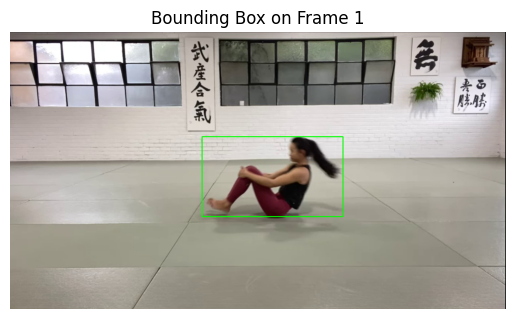

In [12]:
# Visualize some of the data - Manually 

# Read the first frame of the video
cap = cv2.VideoCapture('/mnt/CottonLab/datasets/gymnastics/' + 'gymnastics_test_1.mp4')  # Replace with the actual path
ret, frame = cap.read()
cap.release()

# Convert frame to RGB
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

x_min, y_min, width, height = int(x_min), int(y_min), int(width), int(height)
cv2.rectangle(frame_rgb, (x_min, y_min), (x_min + width, y_min + height), (0, 255, 0), 2)

# Show the image with bounding boxes
plt.imshow(frame_rgb)
plt.axis("off")
plt.title("Bounding Box on Frame 1")
plt.show()

In [ ]:
# Visualize some of the data - Automatically
from pose_pipeline.pipeline import BottomUpBridgingVideo
BottomUpBridgingVideo.populate(skeleton_keys)
BottomUpBridgingVideo() & proj_filt
BottomUpBridgingVideo() & skeleton_keys

video_path = (BottomUpBridgingVideo() & skeleton_keys).fetch("output_video")
print(video_path)

# Display the video in Jupyter Notebook
# Uncomment the following lines to display the video in Jupyter Notebook
# from IPython.display import Video as JupyterVideo
# JupyterVideo(video_path)

## 4. Tracking 

<details>
<summary>Click to Expand Explanation </summary>
Up until this point you have likely run or populated BottomUpBriding and or  BottomUpPeople. These methods have now provided you with boxes, 2D and 3D keypoints and 2D keypoints, respectively for all the people 'seen' in your videos. If your videos contain multiple people it is likely that you are interested in one particular subject. The following steps function to isolate this subject of interest for further analysis. To acomplish this you will need to run Tracking. 
</details>

In [13]:
from pose_pipeline.pipeline import TrackingBbox, TrackingBboxMethod, TrackingBboxMethodLookup

### 4.1. Create Tracking Keys

In [14]:
# select the tracking method you want to use via TrackingBboxMethod table (this is a mannual table)

tracking_method = (TrackingBboxMethodLookup & 'tracking_method_name="MMDet_deepsort"').fetch1('tracking_method')
print('The tracking method is: ', tracking_method)

tracking_keys = (Video & proj_filt).fetch('KEY')
display(tracking_keys)

for key in tracking_keys:
    key["tracking_method"] = tracking_method
    print(key)
    TrackingBboxMethod.insert1(key, skip_duplicates=True)


The tracking method is:  8


[{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_1.mp4'},
 {'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_2.mp4'},
 {'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_3.mp4'},
 {'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_4.mp4'}]

{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_1.mp4', 'tracking_method': 8}
{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_2.mp4', 'tracking_method': 8}
{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_3.mp4', 'tracking_method': 8}
{'video_project': 'gymnastics_TEST', 'filename': 'gymnastics_test_4.mp4', 'tracking_method': 8}


In [15]:
TrackingBboxMethod() & proj_filt
TrackingBboxMethodLookup & 'tracking_method=8'

tracking_method,tracking_method_name
8,MMDet_deepsort


### 4.2.  Run Tracking

In [16]:
TrackingBbox.populate(tracking_keys)

TrackingBbox() & proj_filt

video_project,filename,tracking_method,tracks,num_tracks
gymnastics_TEST,gymnastics_test_1.mp4,8,=BLOB=,6
gymnastics_TEST,gymnastics_test_2.mp4,8,=BLOB=,6
gymnastics_TEST,gymnastics_test_3.mp4,8,=BLOB=,9
gymnastics_TEST,gymnastics_test_4.mp4,8,=BLOB=,132


In [17]:
# View the video with the tracks overlaid by populating the TrackingBboxVideo Table (BlurredVideo has to be populated first)
TrackingBboxVideo.populate(proj_filt)

TrackingBboxVideo & proj_filt

video_project,filename,tracking_method,output_video datajoint managed video file
gymnastics_TEST,gymnastics_test_1.mp4,8,=BLOB=
gymnastics_TEST,gymnastics_test_2.mp4,8,=BLOB=
gymnastics_TEST,gymnastics_test_3.mp4,8,=BLOB=
gymnastics_TEST,gymnastics_test_4.mp4,8,=BLOB=


### 4.3.  Working with the Annotations GUI

<details>
<summary>Click to Expand Explanation</summary>
After populating the TrackingBbox table, if dealing with a multi-person scene and or if you have detections that are not relevant you will need to select the tracking bounding boxes that contain the person that you are intereseted in analyzing. To do this, you will first visually identify the person you wnat and select ALL the tracks that locate them throughout the video. For internal users: follow the link below to access the annotation GUI.

http://jc-compute01.ric.org:8505/

The selected tracks are automatically populated into the PerpsonBboxValid table.
</details>

In [18]:
from pose_pipeline.pipeline import PersonBboxValid
# Populated from annotations GUI
PersonBboxValid & proj_filt

video_project,filename,tracking_method,video_subject_id,keep_tracks
gymnastics_TEST,gymnastics_test_1.mp4,8,0,=BLOB=
gymnastics_TEST,gymnastics_test_2.mp4,8,0,=BLOB=
gymnastics_TEST,gymnastics_test_3.mp4,8,0,=BLOB=
gymnastics_TEST,gymnastics_test_4.mp4,8,0,=BLOB=


### 4.4.  Extract and view the valid tracks

In [19]:
tracks = (PersonBboxValid & proj_filt).fetch('keep_tracks')
display(tracks)

array([list([0, 2, 4, 1, 3]), list([0]), list([0, 2, 7]),
       list([30, 31, 33])], dtype=object)

### 4.5. Popualte PersonBbox

<details>
<summary>Click to Expand Explanation</summary>
PersonBboxValid contains all the selected tracks/boxes that correspond to your person of interest. Next, you will populate PersonBbox which combines all the valid bboxes into a single bbox for the entire video. 
</details>

In [21]:
from pose_pipeline.pipeline import PersonBbox
PersonBbox.populate(proj_filt)
PersonBbox & proj_filt

video_project,filename,tracking_method,video_subject_id,bbox,present
gymnastics_TEST,gymnastics_test_1.mp4,8,0,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_2.mp4,8,0,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_3.mp4,8,0,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_4.mp4,8,0,=BLOB=,=BLOB=


###  4.6. Assess the quality of the tracking

<details>
<summary>Click to Expand Explanation</summary>
Up to this point, you have tracked all people in the scene, selected which bounding boxes are valid or in other words the bounding box(es) that are associated with the subject of interest. DetectedFrames is an optional table that provides insight on the tracking quality. 
Depending on the method you want you can choose top-down or bottom-up. Because we already did part of BotomUpBridging you could populate BottomUpBridgingPerson which essentially filters out the other people in the scene and associates bounding boxes with motion keypoints. On the other hand you can choose to continue with a different top-down approach. 
</details>

In [23]:
from pose_pipeline.pipeline import DetectedFrames

DetectedFrames.populate(proj_filt)
DetectedFrames & proj_filt

video_project,filename,tracking_method,video_subject_id,frames_detected,frames_missed,fraction_found,mean_other_people,median_confidence,frame_data
gymnastics_TEST,gymnastics_test_1.mp4,8,0,420,71,0.855397,0.0794297,0.998408,=BLOB=
gymnastics_TEST,gymnastics_test_2.mp4,8,0,579,0,1.0,1.08636,0.9996,=BLOB=
gymnastics_TEST,gymnastics_test_3.mp4,8,0,77,325,0.191542,2.65423,0.697482,=BLOB=
gymnastics_TEST,gymnastics_test_4.mp4,8,0,510,414,0.551948,22.7576,0.98799,=BLOB=


In [24]:
BottomUpBridgingPerson.populate(proj_filt)

{'success_count': 0, 'error_list': []}

## 5.  Top-Down Methods

<details>
<summary>Click to Expand Explanation</summary>
You may want to run Top-Down approaches as well. This could be because you want to test out some different tracking methods if the tracking performed in BottomUpBridging (OpenPose_Bridging) was not super successful. 
</details>

### 5.1.  Create Top-Down Method key(s)

In [ ]:
top_down_keys = (PersonBbox & proj_filt).fetch('KEY')
display(top_down_keys)

for td in top_down_keys:
    td["top_down_method"] = top_down_method
    TopDownMethod.insert1(td, skip_duplicates=True)

display(TopDownMethod() & proj_filt)

top_down_keys = (TopDownMethod & proj_filt).fetch('KEY')
display(top_down_keys)

### 5.2. Populate the Top-Down Table

In [ ]:
TopDownPerson.populate(proj_filt)
TopDownPerson() & proj_filt

## 6. Lifting

<details>
<summary>Click to Expand Explanation</summary>
The goal of lifting is to take in your 2D keypoints and produce them in 3D. To run lifting you’ll follow the same general principles as previous steps. First you’ll select your lifting method. For this example I will use the ‘Bridging_method_name = “Bridging_bml_movi_87”. You’ll create the key(s) for this specific method by inheriting the keys from TopDownPerson then add your lifting method to the key(s). From here you can check that you have defined all your PKs and populate LiftingPerson. 
</details>

### 6.1.  Create lifting keys

In [28]:
lifting_keys = (TopDownPerson & proj_filt).fetch('KEY')
display(lifting_keys)

for L in lifting_keys:
    L["lifting_method"] = 12
    LiftingMethod.insert1(L, skip_duplicates=True)

display(LiftingMethod() & proj_filt)

lifting_keys = (LiftingMethod & proj_filt).fetch('KEY')
display(top_down_keys)

[{'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_1.mp4',
  'tracking_method': 8,
  'video_subject_id': 0,
  'top_down_method': 12},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_2.mp4',
  'tracking_method': 8,
  'video_subject_id': 0,
  'top_down_method': 12},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_3.mp4',
  'tracking_method': 8,
  'video_subject_id': 0,
  'top_down_method': 12},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_4.mp4',
  'tracking_method': 8,
  'video_subject_id': 0,
  'top_down_method': 12}]

video_project,filename,tracking_method,video_subject_id,top_down_method,lifting_method
gymnastics_TEST,gymnastics_test_1.mp4,8,0,12,12
gymnastics_TEST,gymnastics_test_2.mp4,8,0,12,12
gymnastics_TEST,gymnastics_test_3.mp4,8,0,12,12
gymnastics_TEST,gymnastics_test_4.mp4,8,0,12,12


[{'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_1.mp4',
  'tracking_method': 8,
  'video_subject_id': 0},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_2.mp4',
  'tracking_method': 8,
  'video_subject_id': 0},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_3.mp4',
  'tracking_method': 8,
  'video_subject_id': 0},
 {'video_project': 'gymnastics_TEST',
  'filename': 'gymnastics_test_4.mp4',
  'tracking_method': 8,
  'video_subject_id': 0}]

### 6.2.  Run Lifting

In [29]:
LiftingPerson.populate(proj_filt)
LiftingPerson() & proj_filt

video_project,filename,tracking_method,video_subject_id,top_down_method,lifting_method,keypoints_3d,keypoints_valid
gymnastics_TEST,gymnastics_test_1.mp4,8,0,12,12,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_2.mp4,8,0,12,12,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_3.mp4,8,0,12,12,=BLOB=,=BLOB=
gymnastics_TEST,gymnastics_test_4.mp4,8,0,12,12,=BLOB=,=BLOB=


### View Lifting Video

In [ ]:
LiftingPersonVideo.populate(proj_filt)
LiftingPersonVideo() & proj_filt

<details>
<summary>Click to Expand Final Summary</summary>
 You have now reached the end of the tutorial notebook for PosePipeline. You began with raw images or videos that you wanted to analyze. If done correctly, you should be left with 2D and 3D keypoints that have been associated to the person you are interested in analyzing, along with the keypoint confidences. If you are familiar with marker-based motion capture this is similar to reaching the end of data collection where you are left with the 3D marker positions in space. The keypoints that you have. 
</details>